In [1]:
%matplotlib inline
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from pyzbar import pyzbar
import re
from collections import defaultdict

In [96]:
plt.rcParams["figure.figsize"]=10,10

In [97]:
def prepare_omr_area(filename):
    # assumes the image is with the right orientation
    image = cv.imread(filename)  
    _retval, binary = cv.threshold(image, 128, 255, cv.THRESH_BINARY)
    barcodes = pyzbar.decode(binary)
    if not barcodes:
        return image, None, None, None
    for barcode in barcodes:
        # extract the bounding box location of the qrcode and draw
        # delete (fill with white) the bounding box surrounding the qrcode on the image
        (x, y, w, h) = barcode.rect
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)
    # crop the image just to the barcodes
    tl = np.array(barcodes[0].rect[:2])
    br = np.array(barcodes[1].rect[:2]) + np.array(barcodes[1].rect[2:])
    image = image[tl[1]:br[1], tl[0]:br[0]]
    # get bounding box of the omr area
    bb = None
    qrange = None
    m = re.search(r'\((?P<tl_x>\d+),(?P<tl_y>\d+)\)-\((?P<br_x>\d+),(?P<br_y>\d+)\)/(?P<diag>\d+),(?P<page>\d+)(?:,(?P<qrange_start>\d+)-(?P<qrange_end>\d+))?', str(barcodes[1].data))
    if m:
        tl, br = np.array([m.group('tl_x'), m.group('tl_y')], dtype=float), np.array([m.group('br_x'), m.group('br_y')], dtype=float)
        tl = (tl * image.shape[1] / 100.0 + 0.5).astype(int)
        br = (br * image.shape[1] / 100.0 + 0.5).astype(int)
        bb = image[tl[1]:br[1], tl[0]:br[0]]  
        cv.rectangle(image, tuple(tl), tuple(br), (0, 0, 255), 3)
        qrange = (int(m.group('qrange_start')), int(m.group('qrange_end')))
    seq = None
    m = re.search(r'\[(?P<sequence>[^\]]+)\]', str(barcodes[0].data))
    if m:
        seq = m.group('sequence').split(',')
        seq = seq[qrange[0] - 1:qrange[1]]
    return image, bb, seq, list(range(qrange[0], qrange[1] + 1))

In [98]:
def circle_filled_area(image, c):
    area = 0
    center = np.array([c[0], c[1]])
    radius = c[2]
    xbounds = range(max(0, c[0] - c[2]), min(image.shape[1], c[0] + c[2] + 1))
    ybounds = range(max(0, c[1] - c[2]), min(image.shape[0], c[1] + c[2] + 1))
    for y in ybounds:
        for x in xbounds:
            point = np.array([x, y])
            if cv.norm(point - center) <= radius and image[y, x] > 0:
                area += 1
    return area

In [99]:
### edge detection solution
image, omr_area, correct_sequence, qrange = prepare_omr_area("prova.jpg")
gray = cv.cvtColor(omr_area, cv.COLOR_BGR2GRAY)
gray = cv.GaussianBlur(gray, (5, 5), 2, 2)
_retval, gray = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)
contours, _ = cv.findContours(gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
circles = []
for contour in contours:
    perimeter = cv.arcLength(contour, True)
    approx = cv.approxPolyDP(contour, 0.01 * perimeter, True)
    (cx, cy), radius = cv.minEnclosingCircle(contour)
    if len(approx) >= 8:                        
        circles.append((int(cx), int(cy), int(radius)))
        #cv.circle(omr_area, (int(cx), int(cy)), int(radius), (255, 0, 0), 3)
circles = sorted(circles)
# find the reference_circles first
pivot = circles[0]
reference_circles = [c for c in circles if abs(c[0] - pivot[0]) <= pivot[2]]
other_circles = [c for c in circles if abs(c[0] - pivot[0]) > pivot[2]]
for c in reference_circles:
    cv.circle(omr_area, c[:2], c[2], (255, 0, 255), 3)
mean_area = np.mean(np.fromiter((c[2] * c[2] * np.pi for c in reference_circles), float))
answer_circles = defaultdict(lambda: [])

# remaning circles
for c in other_circles:
    # find the closest reference circle, w.r.t. y coordinate
    ydist = np.fromiter((abs(c[1] - rc[1]) for rc in reference_circles), int)
    reference_circle = reference_circles[np.argmin(ydist)]
    filled_area = circle_filled_area(gray, c)
    if filled_area / mean_area > 0.4:
#        cv.circle(omr_area, c[:2], c[2], (0, 0, 255), 3)
        answer_circles[reference_circle].append(c + (True,))
    else:
#        cv.circle(omr_area, c[:2], c[2], (0, 255, 255), 3)
        answer_circles[reference_circle].append(c + (False,))   
answer_circles = sorted(answer_circles.items(), key=lambda item: item[0][1])
if len(answer_circles) > len(correct_sequence):
    raise ValueError("Not enough answers {}".format(correct_sequence))
correction = []
for i, ac in enumerate(answer_circles):
    correct_res = set(correct_sequence[i])
    all_res = set()
    answers_res = set()    
    for j, c in enumerate(ac[1]):
        r = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"[j]
        all_res.add(r)
        if c[3]:
            answers_res.add(r)
            if r in correct_res:
                cv.circle(omr_area, c[:2], c[2], (0, 255, 0), 5)
            else:
                cv.circle(omr_area, c[:2], c[2], (255, 0, 0), 5)
        else:
            if r in correct_res:
                cv.circle(omr_area, c[:2], c[2], (255, 0, 0), 5)
    missing_answers = correct_res - all_res
    if len(missing_answers) > 0:
        raise ValueError("For question {}, the correct answer{} {} {} not printed on the sheet".format(qrange[i], "s" if len(missing_answers) > 1 else "", missing_answers, "were" if len(missing_answers) > 1 else "was"))
    p = np.array(ac[0][0:2]) + [-ac[0][2], ac[0][2] + 40]
    tmp = "".join(a for a in answers_res) if answers_res else "None"
    tmp += "/" + "".join(a for a in correct_res)
    cv.putText(omr_area, tmp, tuple(p), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 3)
    correction.append((answers_res, correct_res))
plt.imshow(omr_area)
print(correction)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
def check_answer_correctness(correction, **kwargs):
    marking = []
    for question in correction:
        correct_rate = len(question[0] & question[1]) / len(question[1])
        wrong_rate = len(question[0] - question[1]) / len(question[1])
        marking.append((2.0 * correct_rate - wrong_rate) / 2.0)
    return marking

In [100]:
check_answer_correctness(correction)

[-1.0, 0.5]

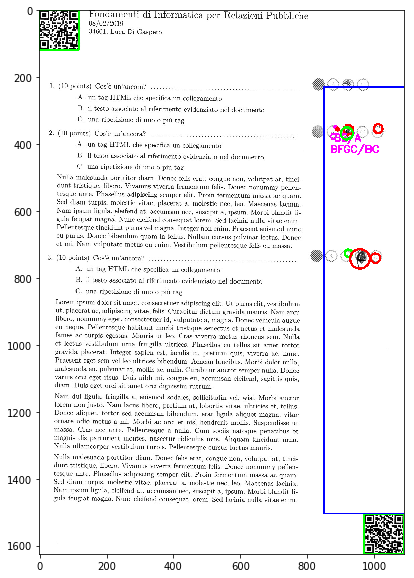

In [101]:
plt.imshow(image)